# Conducting Between Analysis Between Region

Here we conduct physical analysis between basins.

1) We download a handful of floats into a parquet and estimate potential density and calculate MLD

2) Expansion into a larger dataset, Here we expand nº1 into a larger dataset and seperating into regions

In [1]:
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

In [2]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

# Downloading Handful of floats

Downloading speific floats and estiamte physical parameters

## Downloading Floats 

In [33]:
# Base filepath
root = '../data/argo/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'argo' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

# Downloading data using argopy
float_ids = [6903871, 6902882, 6902802, 6901627, 6902807, 6901601, 6901029]  # Ice Shelf and Open Ocean Floats

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard').float(
                     float_ids).to_xarray()

# Quality Control Filtering
ds = ds.argo.filter_qc(QC_list=[1,2])  # Keep only good and probably good data

# Downloading data using argopy

ds = ds.to_dataframe().reset_index()
ds = pl.from_pandas(ds)

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")


Saved all float in one parquet -> ../data/argo/Profiles/


## Comparing Basins

Creating Function:

1) density Calcl
2) Sigma0 Potential density
3) Estimating Mixlayer depth using the density threshold of ~0.3

In [34]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [35]:
# Loading data 
df = pl.read_parquet('../data/argo/profiles/Grouped_data_set.parquet')

# Filtering data below 500m
df = df.filter(pl.col('PRES') < 500)

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing CHL per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()




N_POINTS,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ERROR,PRES_QC,PSAL,PSAL_ERROR,PSAL_QC,TEMP,TEMP_ERROR,TEMP_QC,TIME_QC,TIME,LATITUDE,LONGITUDE,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,i64,f32,f32,i64,f32,f32,i64,i64,datetime[ns],f64,f64,f64,f64
0,1,"""D""","""D""",6901029,1,17.0,2.4,1,34.799999,0.01,1,11.131,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,26.600054,17.0
1,1,"""D""","""D""",6901029,1,24.0,2.4,1,34.882,0.01,1,8.478,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.111274,17.0
2,1,"""D""","""D""",6901029,1,34.0,2.4,1,34.872002,0.01,1,6.765,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.352959,17.0
3,1,"""D""","""D""",6901029,1,45.0,2.4,1,34.865002,0.01,1,6.177,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.425852,17.0
4,1,"""D""","""D""",6901029,1,55.0,2.4,1,34.896,0.01,1,5.682,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.513338,17.0


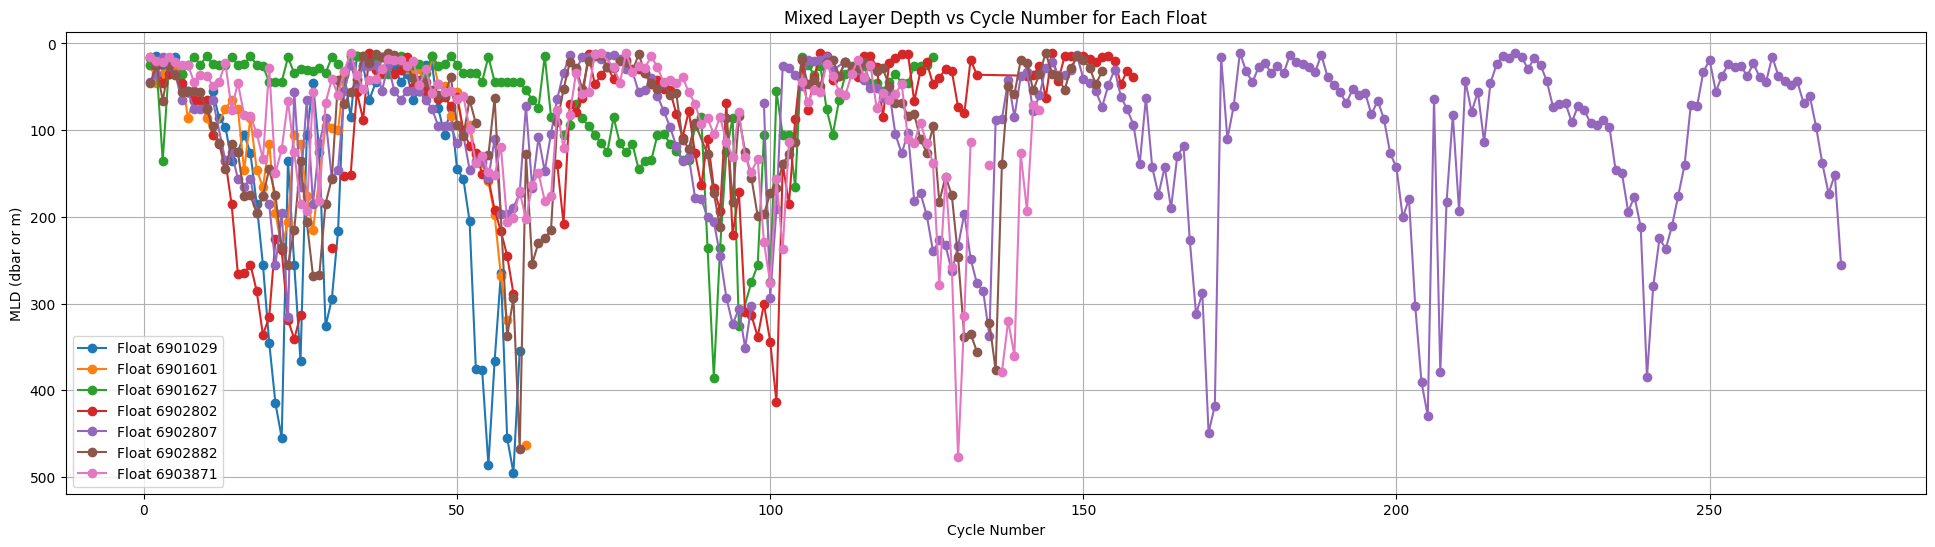

In [36]:
# Plotting df

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

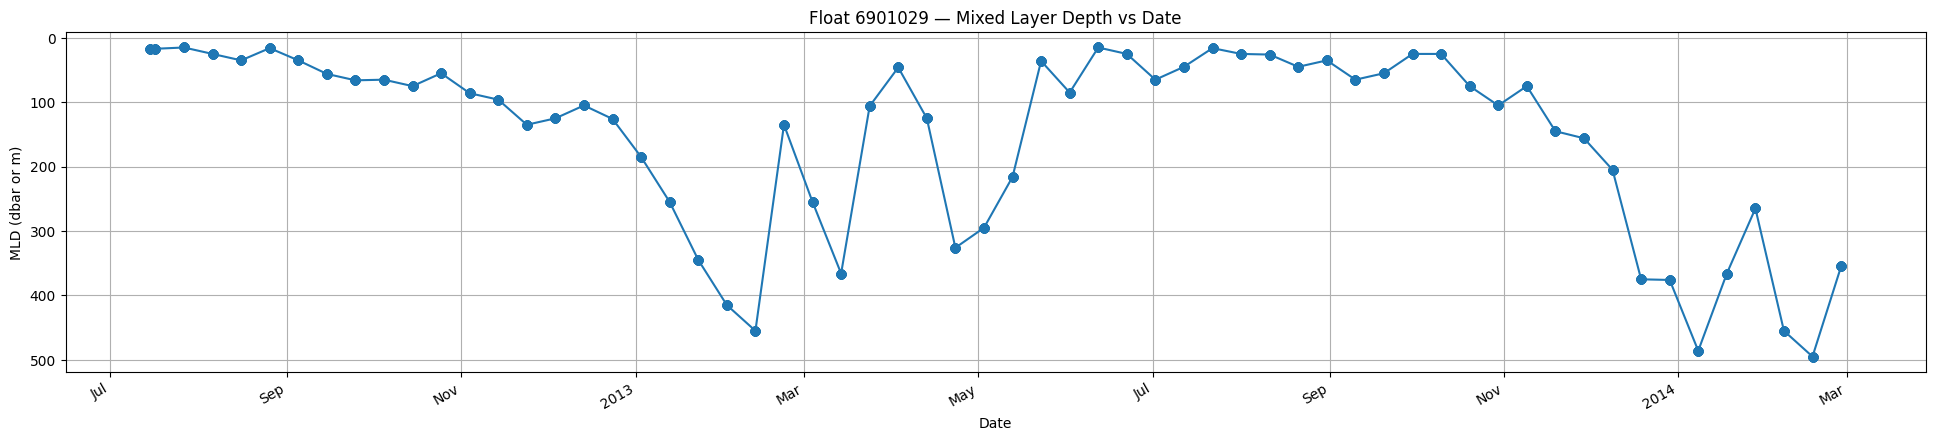

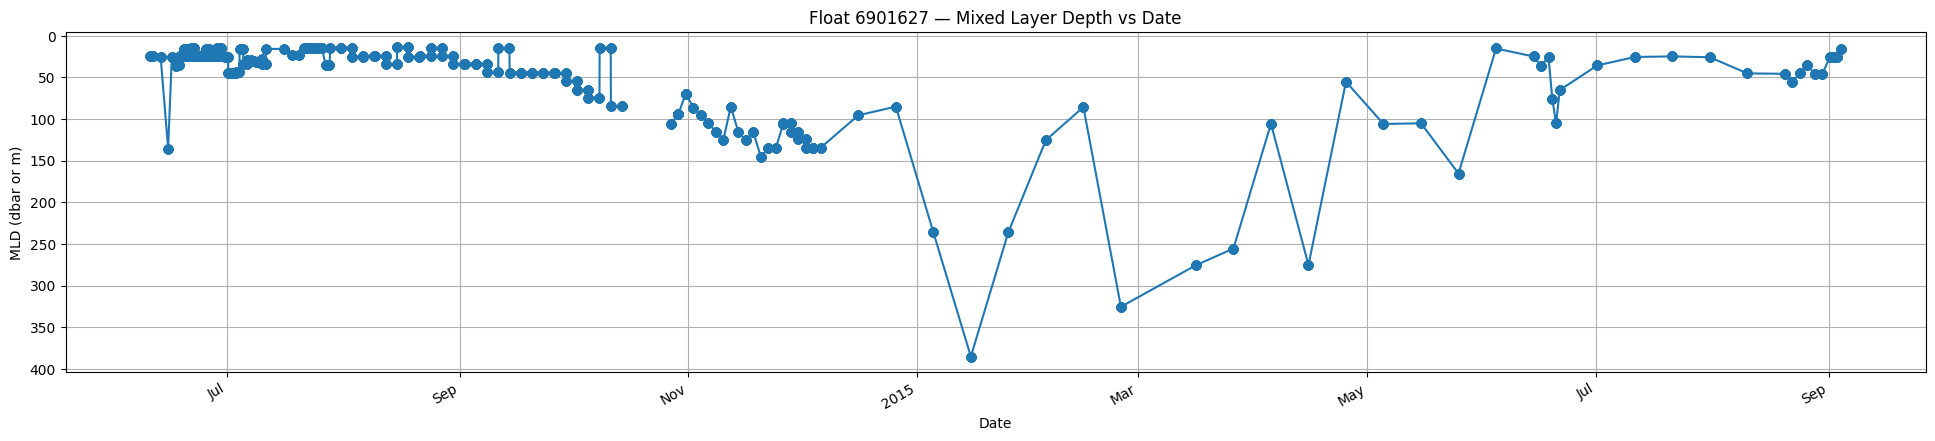

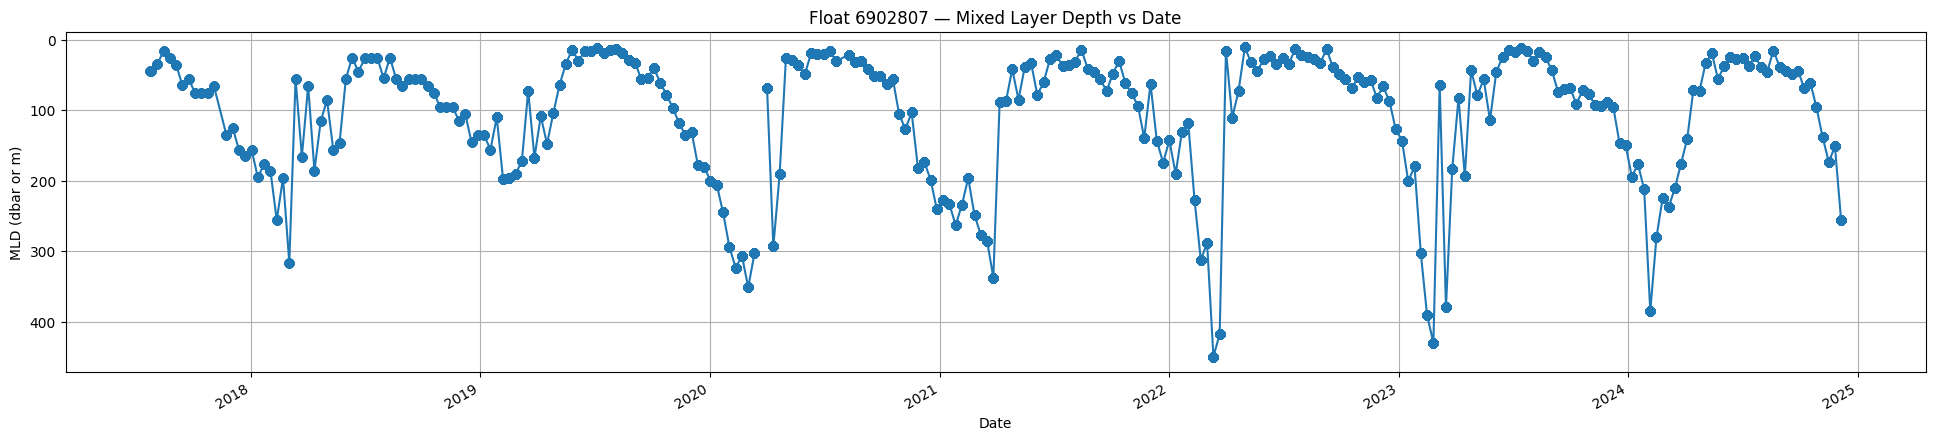

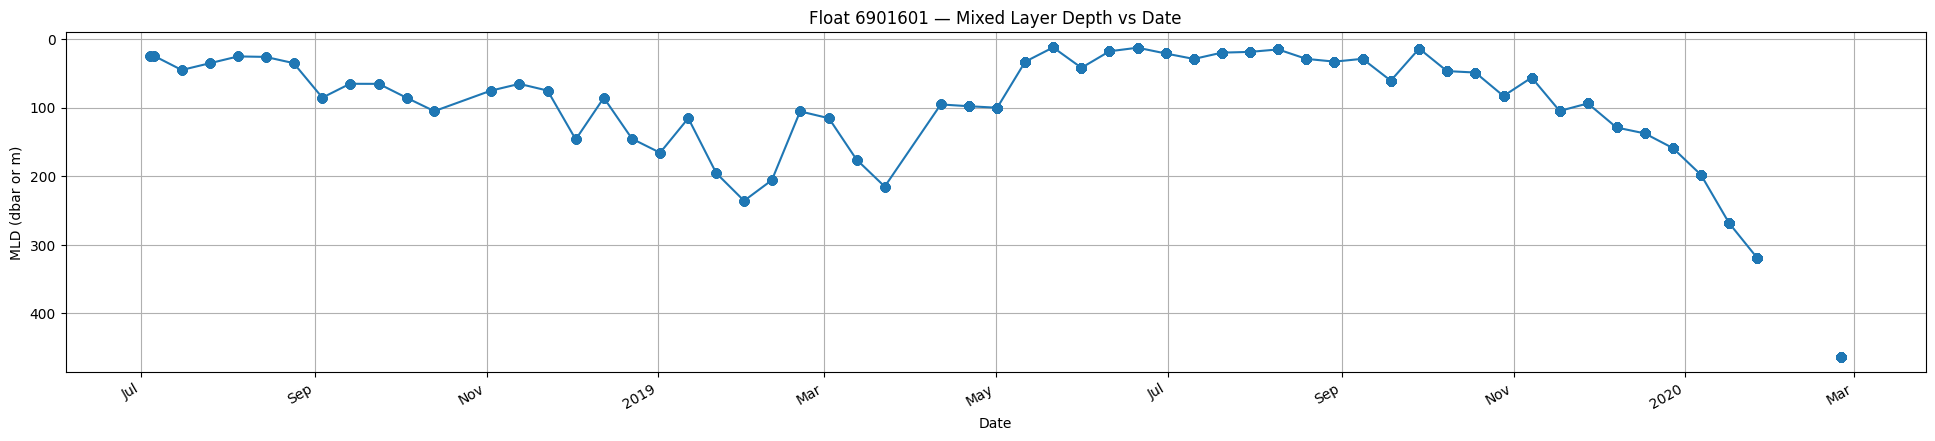

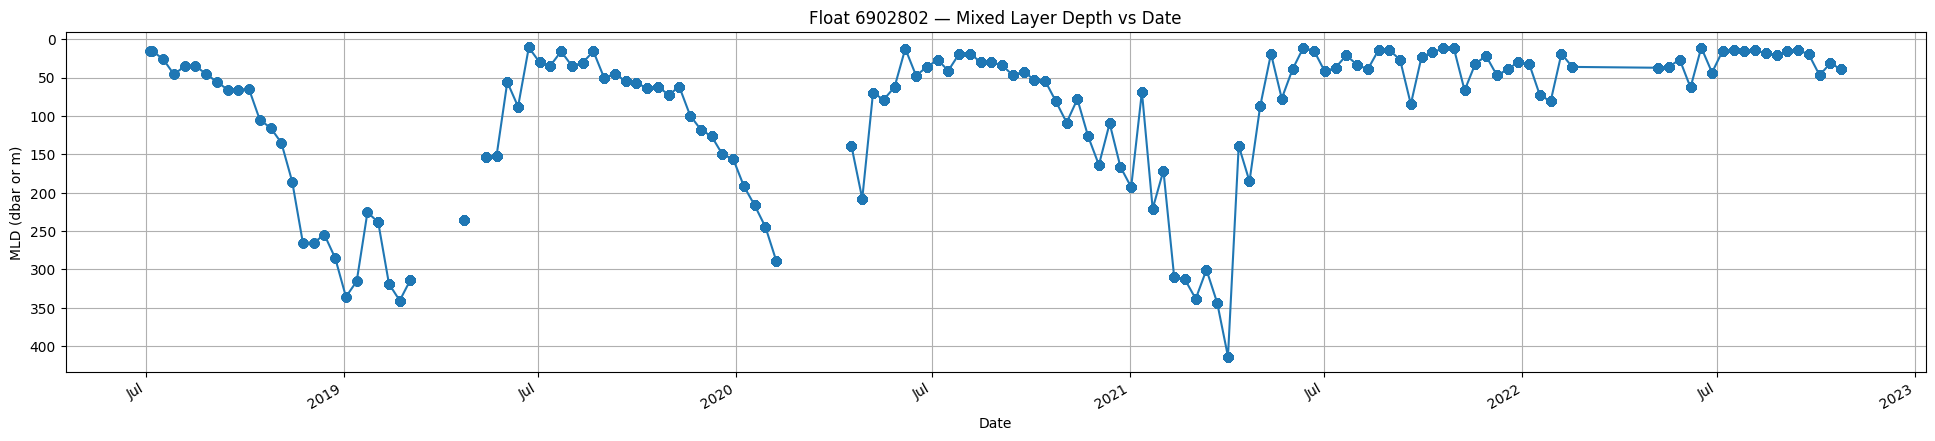

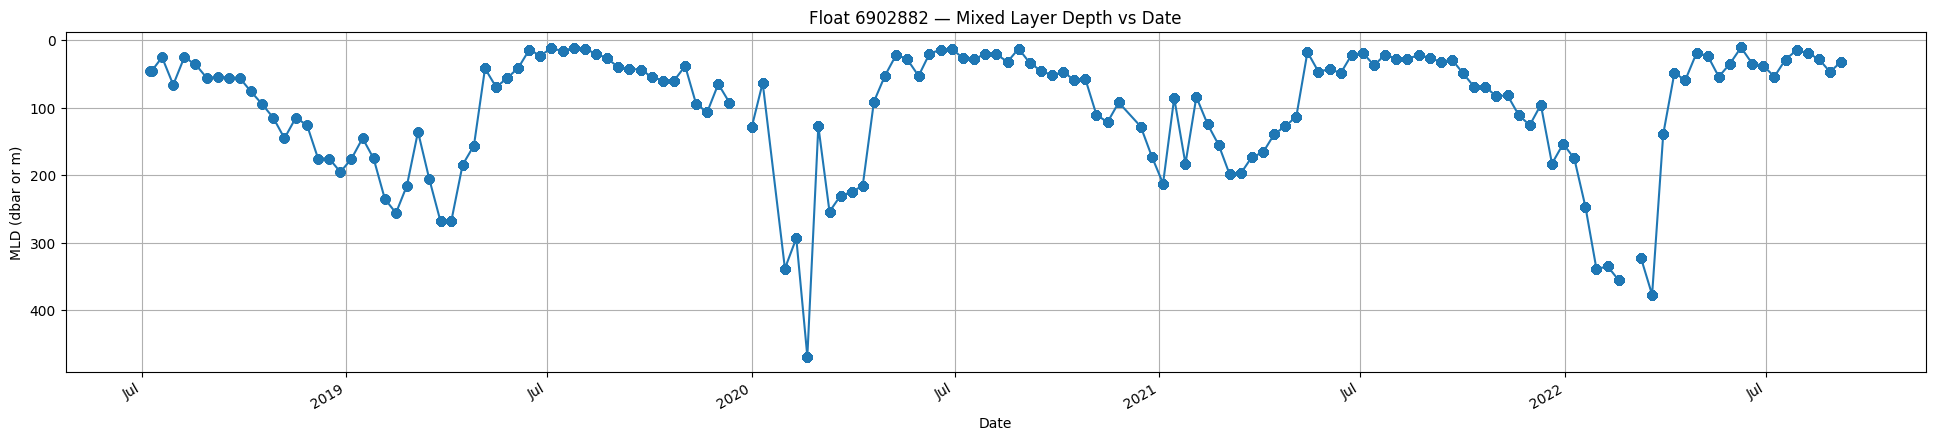

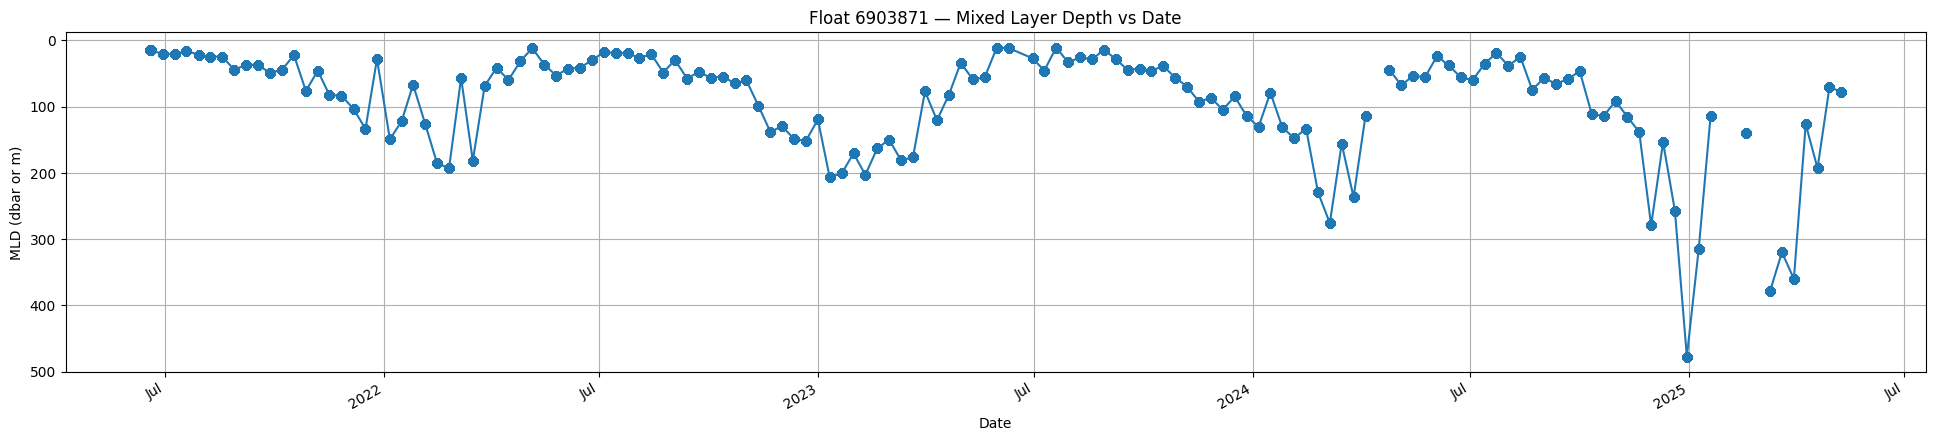

In [37]:
pd_df = df.to_pandas()

# Make sure your date column is a proper datetime
# Example: if your column is 'JULD', convert like:
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])

# Filter by each float and plot
for fid in pd_df['PLATFORM_NUMBER'].unique():
    sub = pd_df[pd_df['PLATFORM_NUMBER'] == fid]
    # Summarise one MLD per cycle (assuming one MLD per cycle)
    summary = sub.groupby('CYCLE_NUMBER').agg({
        'TIME': 'first',   # or maybe 'min' or 'max' depending
        'MLD': 'first'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(24,5))
    ax.plot(sub['TIME'], sub["MLD"],
            marker="o", label=f"Float {float_id}")
    ax.set_title(f"Float {fid} — Mixed Layer Depth vs Date")
    ax.set_xlabel("Date")
    ax.set_ylabel("MLD (dbar or m)")
    ax.invert_yaxis()  # deeper depth = larger number → put deeper downwards
    # Format the x-axis as dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

# Expanded Dataset

## Download
Here we download all profiles within region since 2014. Download are stored as Regional_Argo_Tablet.parquet. 

In [19]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

# Pacakages for data handling
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [20]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [41]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-36, -10, 55, 67, 0, 3000, '2015-08', '2025-08']

### Get more info about this region using the ArgoIndex

In [21]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (366074 records)
Searched: False

In [22]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [23]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [24]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
#[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM']]  # Remove core variables from the list
bgc_params

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [25]:
# How many different floats in the region:
len(idx.read_wmo())

111

### Load all Physical data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [46]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 4min 43s, sys: 46.9 s, total: 5min 30s
Wall time: 15min 48s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-36.00/-10.00; y=55.00/67.00; z=0.0/3000.0; t=2015-08-01/2025-08-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [47]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 7GB
Dimensions:                   (N_POINTS: 5945314)
Coordinates:
    LATITUDE                  (N_POINTS) float64 48MB 61.88 61.88 ... 60.97
    LONGITUDE                 (N_POINTS) float64 48MB -35.27 -35.27 ... -17.64
    TIME                      (N_POINTS) datetime64[ns] 48MB 2015-08-01T22:29...
  * N_POINTS                  (N_POINTS) int64 48MB 0 1 2 ... 5945312 5945313
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 48MB 2 2 2 2 2 2 ... 4 4 4 4 4 4
    CYCLE_NUMBER              (N_POINTS) int64 48MB 113 113 113 113 ... 77 77 77
    DATA_MODE                 (N_POINTS) <U1 24MB 'D' 'D' 'D' ... 'A' 'A' 'A'
    DIRECTION                 (N_POINTS) <U1 24MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 48MB 6901022 6901022 ... 1902621
    POSITION_QC               (N_POINTS) int64 48MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 24MB 9.423 9.425 ... 2.621
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 24MB 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_POINTS) int64 48MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TEMP_QC                   (N_POINTS) int64 48MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TIME_QC                   (N_POINTS) int64 48MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 6GB 'Primary sampling: average...
Attributes: (7)

In [48]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(5945314) ~ N_PROF(18389) x N_LEVELS(3989)

In [37]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

NameError: name 'ds' is not defined

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2025-04-02 01:34:00,66.989793,-24.404108,6990657,13
1,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
2,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
3,2024-06-22 12:51:02,59.830355,-21.894241,6990636,10
4,2024-06-19 00:44:28,59.556890,-21.006004,6990636,9
...,...,...,...,...,...
18384,2025-06-19 11:40:58,61.793573,-29.307393,7902223,39
18385,2025-06-29 11:40:58,61.840967,-28.672233,7902223,40
18386,2025-07-09 11:42:58,62.354914,-28.088273,7902223,41
18387,2025-07-19 11:39:28,63.368121,-27.901616,7902223,42


In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
2,113,"""D""","""A""",6901022,1,3.0,3.0,2.4,1,1,34.890999,34.890999,0.01,1,1,9.423,9.423,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00
2,113,"""D""","""A""",6901022,1,4.0,4.0,2.4,1,1,34.902,34.902,0.01,1,1,9.425,9.425,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00
2,113,"""D""","""A""",6901022,1,5.0,5.0,2.4,1,1,34.907001,34.907009,0.01,1,1,9.423,9.423,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00
2,113,"""D""","""A""",6901022,1,6.0,6.0,2.4,1,1,34.908001,34.908001,0.01,1,1,9.424,9.424,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00
2,113,"""D""","""A""",6901022,1,7.0,7.0,2.4,1,1,34.907001,34.907009,0.01,1,1,9.426,9.426,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00


### Load all BGC data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [26]:
BOX = [-36, -10, 55, 67, 0, 3000, '2010-08', '2025-08']

In [27]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 47min 13s, sys: 3min 20s, total: 50min 34s
Wall time: 1h 3min 48s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-36.00/-10.00; y=55.00/67.00; z=0.0/3000.0; t=2010-08-01/2025-08-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['BBP532', 'BBP700', 'BISULFIDE', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'DOXY2', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
📕 BGC 'must be measured' parameters: []
🏄 User mode: expert
🟢 Dataset: bgc-s
🌤  Performances: cache=False, parallel=True [thread]

In [28]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 3GB
Dimensions:                            (N_POINTS: 5603036)
Coordinates:
    LATITUDE                           (N_POINTS) float64 45MB 56.39 ... 60.97
    LONGITUDE                          (N_POINTS) float64 45MB -29.82 ... -17.64
    TIME                               (N_POINTS) datetime64[ns] 45MB 2010-08...
  * N_POINTS                           (N_POINTS) int64 45MB 0 1 ... 5603035
Data variables: (12/108)
    BBP532                             (N_POINTS) float32 22MB nan nan ... nan
    BBP532_ADJUSTED                    (N_POINTS) float32 22MB nan nan ... nan
    BBP532_ADJUSTED_ERROR              (N_POINTS) float32 22MB nan nan ... nan
    BBP532_ADJUSTED_QC                 (N_POINTS) int64 45MB 99999 ... 99999
    BBP532_DATA_MODE                   (N_POINTS) <U1 22MB '' '' '' ... '' '' ''
    BBP532_QC                          (N_POINTS) int64 45MB 99999 ... 99999
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 22MB nan nan ... 2.621
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 22MB nan nan ... 0.002
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 45MB 4 4 1 1 ... 8 1 8 1
    TEMP_DATA_MODE                     (N_POINTS) <U1 22MB 'D' 'D' ... 'A' 'A'
    TEMP_QC                            (N_POINTS) int64 45MB 3 1 1 1 ... 8 1 8 1
    TIME_QC                            (N_POINTS) int64 45MB 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [29]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(5603036) ~ N_PROF(7438) x N_LEVELS(4670)

In [30]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [31]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

In [32]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,dac,profiler
0,aoml/1902304/profiles/SD1902304_157.nc,2024-03-21 21:21:39,55.297,-18.833,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:37,1902304,157,"AOML, USA",aoml,NAVIS_EBR
1,aoml/1902304/profiles/SD1902304_158.nc,2024-03-31 21:31:53,55.727,-18.865,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:48,1902304,158,"AOML, USA",aoml,NAVIS_EBR
2,aoml/1902304/profiles/SD1902304_159.nc,2024-04-10 21:11:20,56.325,-18.987,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:59,1902304,159,"AOML, USA",aoml,NAVIS_EBR
3,aoml/1902304/profiles/SD1902304_160.nc,2024-04-20 21:24:52,56.290,-18.758,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:32:10,1902304,160,"AOML, USA",aoml,NAVIS_EBR
4,aoml/1902304/profiles/SD1902304_161.nc,2024-04-30 21:30:20,56.509,-18.912,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:32:21,1902304,161,"AOML, USA",aoml,NAVIS_EBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7403,meds/4901779/profiles/SD4901779_188.nc,2020-07-06 13:45:00,62.149,-32.082,A,865,ME,PRES TEMP PSAL DOXY,DDDR,2025-10-09 23:20:08,4901779,188,"MEDS, Canada",meds,NOVA float with SBE conductivity sensor
7404,meds/4901779/profiles/SD4901779_189.nc,2020-07-16 13:47:00,62.034,-33.050,A,865,ME,PRES TEMP PSAL DOXY,DDDR,2025-10-09 23:20:17,4901779,189,"MEDS, Canada",meds,NOVA float with SBE conductivity sensor
7405,meds/4901779/profiles/SD4901779_190.nc,2020-07-26 13:40:00,62.145,-32.631,A,865,ME,PRES TEMP PSAL DOXY,DDDR,2025-10-09 23:20:27,4901779,190,"MEDS, Canada",meds,NOVA float with SBE conductivity sensor
7406,meds/4901779/profiles/SD4901779_191.nc,2020-08-05 13:41:00,62.195,-33.967,A,865,ME,PRES TEMP PSAL DOXY,DDDR,2025-10-09 23:20:36,4901779,191,"MEDS, Canada",meds,NOVA float with SBE conductivity sensor


In [33]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,DOXY_QC,NITRATE,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns]
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,0.0,0.0,2.4,1,"""D""",1,34.801998,null,null,4,"""D""",3,12.661,null,null,4,"""D""",3,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,6.0,6.0,2.4,1,"""D""",1,34.806999,null,null,4,"""D""",3,12.664,null,null,4,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,17.0,17.0,2.4,1,"""D""",1,34.806999,34.806999,0.01,1,"""D""",1,12.666,12.666,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,26.0,26.0,2.4,1,"""D""",1,34.807999,34.807999,0.01,1,"""D""",1,12.662,12.662,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,36.0,36.0,2.4,1,"""D""",1,34.814999,34.814999,0.01,1,"""D""",1,12.633,12.633,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00


### Tagging By Float By Region

Creating polygons to produce a polygone mask to seperate dataset

In [40]:
# -*- coding: utf-8 -*-
"""
Apply two custom geographic shapes to TWO parquet datasets and write results back in place.
Adds a 'region' column with values: 'shape1', 'shape2', or 'Other'.

Shapes:
  Shape 1 (Ismingter Basin):
    -35 <= lon <= -25
    lat_min = 56 + 0.8*(lon + 35)
    lat_min <= lat <= 66

  Shape 2 (Icelanding Basin):
    -34 <= lon <= -10
    lat_upper = lon + 89  if lon <= -25 else 64
    lat_lower = 55        if lon <= -22 else 66 + 0.5*lon
    lat_lower <= lat <= lat_upper
"""

import numpy as np
import pandas as pd
from pathlib import Path

# Optional ETOPO1
USE_DEEP_OCEAN_MASK = False            # set True to enforce seafloor z <= -1000 m
ETOPO1_PATH = Path("../data/etopo1_subset.nc")   # expects variables: z, longitude, latitude

# Inputs to process (will be OVERWRITTEN in place)
PARQUETS = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),  # <-- note: no space after '-'
]

COL_LON = "LONGITUDE"
COL_LAT = "LATITUDE"

# If both shapes match, which one wins?
OVERLAP_PRECEDENCE = "shape2_over_shape1"  # or "shape1_over_shape2"

# ----------------- helpers -----------------
def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

def load_etopo(path):
    import xarray as xr
    if not path.exists():
        print(f"[WARN] ETOPO file not found at {path}. Deep-ocean mask will be skipped.")
        return None
    ds = xr.open_dataset(path)
    for k in ("z", "longitude", "latitude"):
        if k not in ds:
            raise ValueError("ETOPO dataset must contain variables 'z', 'longitude', 'latitude'.")
    return ds

def deep_mask_from_etopo(ds, lonp, latp, thresh=-1000.0):
    zi = ds["z"].interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    return zi <= float(thresh)

def classify_shapes(lonp, latp):
    # Shape 1
    lon_ok_1 = (lonp >= -35.0) & (lonp <= -25.0)
    lat_min_1 = 56.0 + 0.8*(lonp + 35.0)
    lat_low_ok_1  = (latp >= lat_min_1)
    lat_high_ok_1 = (latp <= 66.0)
    in_shape1 = lon_ok_1 & lat_low_ok_1 & lat_high_ok_1

    # Shape 2
    lon_ok_2 = (lonp >= -34.0) & (lonp <= -10.0)
    lat_upper_2 = np.where(lonp <= -25.0, lonp + 89.0, 64.0)
    lat_lower_2 = np.where(lonp <= -22.0, 55.0, 66.0 + 0.5*lonp)
    lat_low_ok_2  = (latp >= lat_lower_2)
    lat_high_ok_2 = (latp <= lat_upper_2)
    in_shape2 = lon_ok_2 & lat_low_ok_2 & lat_high_ok_2

    debug = {
        "lon_ok_1": lon_ok_1, "lat_low_ok_1": lat_low_ok_1, "lat_high_ok_1": lat_high_ok_1,
        "lon_ok_2": lon_ok_2, "lat_low_ok_2": lat_low_ok_2, "lat_high_ok_2": lat_high_ok_2,
    }
    return in_shape1, in_shape2, debug

def assign_labels(in1, in2, precedence="shape2_over_shape1"):
    labels = np.full(len(in1), "Other", dtype=object)
    if precedence == "shape2_over_shape1":
        labels[in1] = "shape1"
        labels[in2] = "shape2"   # overrides where both True
    elif precedence == "shape1_over_shape2":
        labels[in2] = "shape2"
        labels[in1] = "shape1"   # overrides where both True
    else:
        raise ValueError("precedence must be 'shape2_over_shape1' or 'shape1_over_shape2'")
    return labels

def process_one(parquet_path, ds_etopo=None, use_deep=False):
    print(f"\n======== Processing: {parquet_path.name} ========")
    if not parquet_path.exists():
        print(f"[WARN] Missing parquet: {parquet_path} (skipping)")
        return

    df = pd.read_parquet(parquet_path).copy()

    if COL_LON not in df.columns or COL_LAT not in df.columns:
        raise KeyError(f"Expected columns '{COL_LON}' and '{COL_LAT}' in {parquet_path}")

    LON_raw = df[COL_LON].astype(float).to_numpy()
    LAT = df[COL_LAT].astype(float).to_numpy()
    LON = to_minus180_180(LON_raw)

    print(f"Lon raw range: {np.nanmin(LON_raw):.3f} → {np.nanmax(LON_raw):.3f}")
    print(f"Lon norm range: {np.nanmin(LON):.3f} → {np.nanmax(LON):.3f}")
    print(f"Lat range: {np.nanmin(LAT):.3f} → {np.nanmax(LAT):.3f}")
    print(f"N rows: {len(df)}")

    in1, in2, dbg = classify_shapes(LON, LAT)

    print("\n-- Shape 1 --")
    print("lon_ok_1:", int(dbg["lon_ok_1"].sum()))
    print("lat_low_ok_1:", int(dbg["lat_low_ok_1"].sum()))
    print("lat_high_ok_1:", int(dbg["lat_high_ok_1"].sum()))
    print("in_shape1:", int(in1.sum()))

    print("\n-- Shape 2 --")
    print("lon_ok_2:", int(dbg["lon_ok_2"].sum()))
    print("lat_low_ok_2:", int(dbg["lat_low_ok_2"].sum()))
    print("lat_high_ok_2:", int(dbg["lat_high_ok_2"].sum()))
    print("in_shape2:", int(in2.sum()))

    if use_deep:
        if ds_etopo is None:
            raise RuntimeError("USE_DEEP_OCEAN_MASK=True but no ETOPO dataset loaded.")
        deep = deep_mask_from_etopo(ds_etopo, LON, LAT, thresh=-1000.0)
        print(f"\nDeep-ocean (<= -1000 m): {int(deep.sum())}/{len(deep)}")
        in1 &= deep
        in2 &= deep

    labels = assign_labels(in1, in2, precedence=OVERLAP_PRECEDENCE)
    df["region"] = labels

    # Overwrite the original parquet
    df.to_parquet(parquet_path, index=False)
    print("\nWrote:", parquet_path)
    print("Region counts:\n", pd.Series(labels).value_counts(dropna=False).to_string())

# ----------------- main -----------------
def main():
    ds = load_etopo(ETOPO1_PATH) if USE_DEEP_OCEAN_MASK else None
    for pq in PARQUETS:
        process_one(pq, ds_etopo=ds, use_deep=USE_DEEP_OCEAN_MASK)

if __name__ == "__main__":
    main()


======== Processing: Regional_Argo_Tablet.parquet ========
Lon raw range: -36.000 → -10.002
Lon norm range: -36.000 → -10.002
Lat range: 55.001 → 66.999
N rows: 5945314

-- Shape 1 --
lon_ok_1: 3264393
lat_low_ok_1: 2102649
lat_high_ok_1: 5856935
in_shape1: 1808666

-- Shape 2 --
lon_ok_2: 5298864
lat_low_ok_2: 5454275
lat_high_ok_2: 3413253
in_shape2: 2922214

Wrote: ../data/argo/Region/Regional_Argo_Tablet.parquet
Region counts:
 shape2    2922214
shape1    1808666
Other     1214434

======== Processing: Regional_BGC-Argo_Tablet.parquet ========
Lon raw range: -36.000 → -10.004
Lon norm range: -36.000 → -10.004
Lat range: 55.003 → 66.981
N rows: 5603036

-- Shape 1 --
lon_ok_1: 3311777
lat_low_ok_1: 2547411
lat_high_ok_1: 5584819
in_shape1: 2204071

-- Shape 2 --
lon_ok_2: 4809809
lat_low_ok_2: 5483150
lat_high_ok_2: 2886754
in_shape2: 2766868

Wrote: ../data/argo/Region/Regional_BGC-Argo_Tablet.parquet
Region counts:
 shape2    2766868
shape1    2204071
Other      632097



===== Regional_Argo_Tablet.parquet =====
TIME range: 2015-08-01 21:43:07 → 2025-07-31 11:51:57


,region,year,month,profile_count
0,Other,2015,8,26
1,Other,2015,9,24
2,Other,2015,10,32
3,Other,2015,11,37
4,Other,2015,12,30
5,Other,2016,1,31
6,Other,2016,2,18
7,Other,2016,3,22
8,Other,2016,4,25
9,Other,2016,5,23


,region,year,week,profile_count
0,Other,2015,31,1
1,Other,2015,32,7
2,Other,2015,33,6
3,Other,2015,34,4
4,Other,2015,35,8
5,Other,2015,36,6
6,Other,2015,37,8
7,Other,2015,38,3
8,Other,2015,39,6
9,Other,2015,40,6


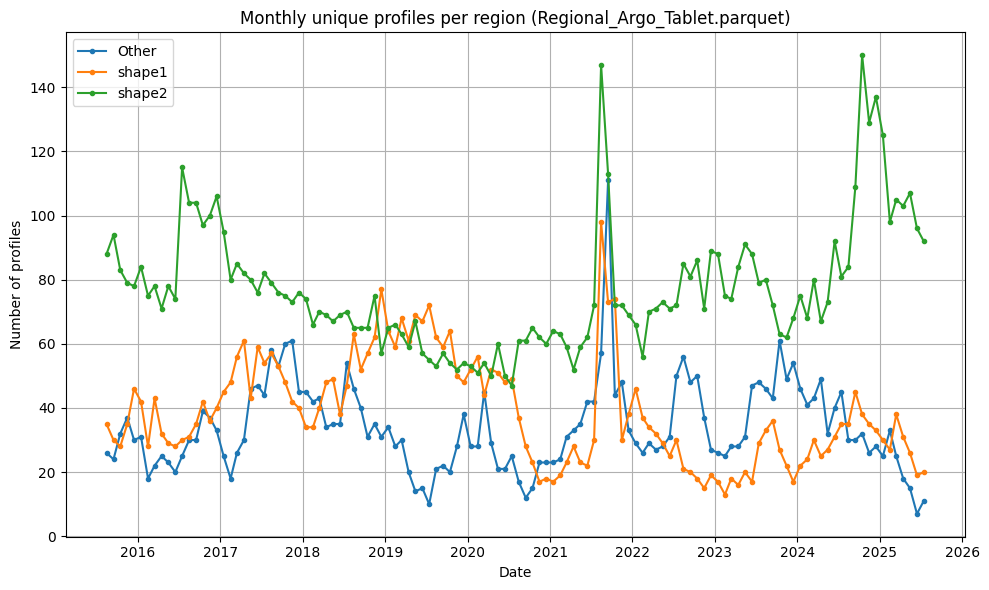

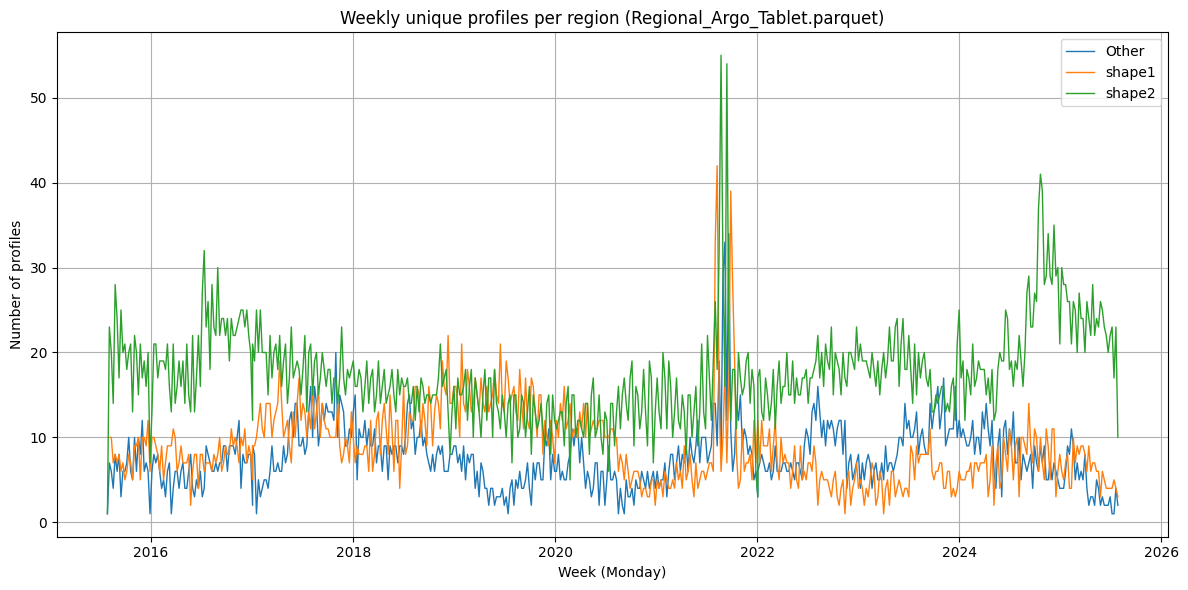


===== Regional_BGC-Argo_Tablet.parquet =====
TIME range: 2010-08-05 04:35:00 → 2025-07-31 11:51:57.020999936


,region,year,month,profile_count
0,Other,2010,8,3
1,Other,2010,10,4
2,Other,2010,11,5
3,Other,2010,12,4
4,Other,2011,1,3
5,Other,2011,2,5
6,Other,2011,3,3
7,Other,2011,4,2
8,Other,2011,5,1
9,Other,2011,6,2


,region,year,week,profile_count
0,Other,2010,33,2
1,Other,2010,34,1
2,Other,2010,39,1
3,Other,2010,41,2
4,Other,2010,42,1
5,Other,2010,44,2
6,Other,2010,45,1
7,Other,2010,46,1
8,Other,2010,47,1
9,Other,2010,48,1


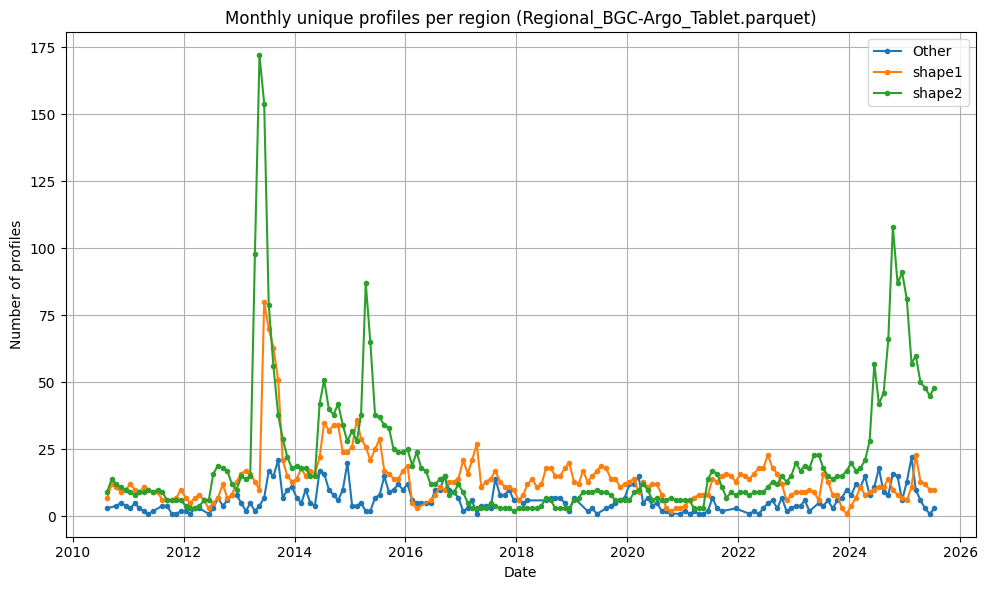

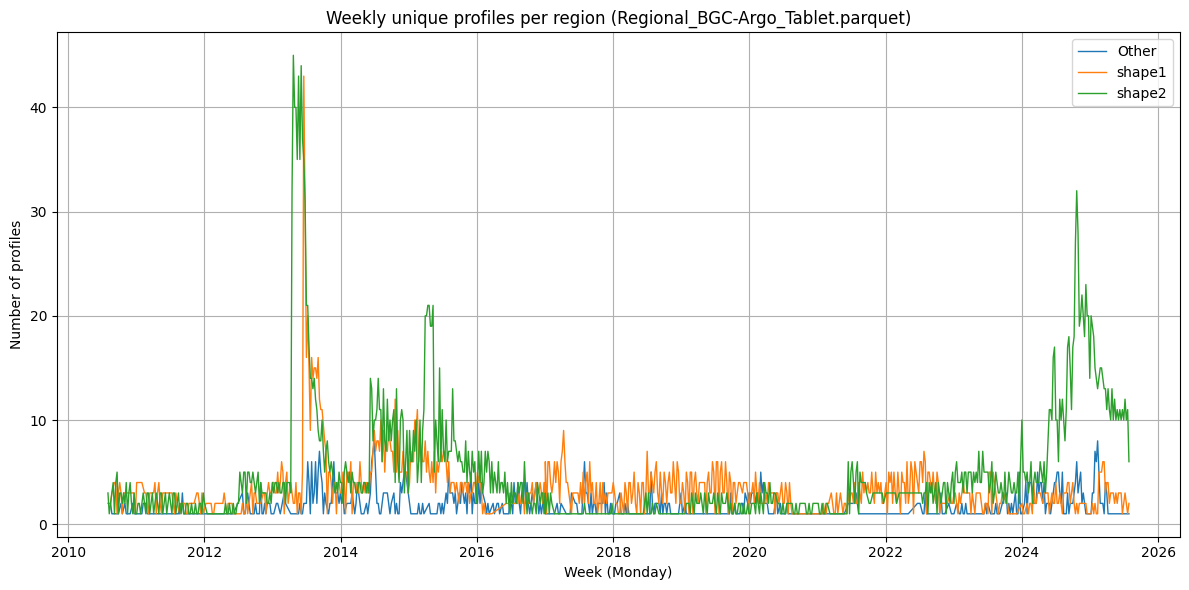

In [41]:
# --- Quick check: number of unique profiles per region for BOTH datasets ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Files to analyze
parquets = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
]

# Columns (adjust if needed)
COL_TIME = "TIME"
COL_PLATFORM = "PLATFORM_NUMBER"
COL_CYCLE = "CYCLE_NUMBER"
COL_REGION = "region"

for parquet_path in parquets:
    print(f"\n===== {parquet_path.name} =====")
    df = pd.read_parquet(parquet_path)

    # --- Parse datetime ---
    df[COL_TIME] = pd.to_datetime(df[COL_TIME], errors="coerce", utc=True).dt.tz_convert(None)
    print("TIME range:", df[COL_TIME].min(), "→", df[COL_TIME].max())

    # --- Each (platform, cycle, region) = one profile ---
    profiles = df.drop_duplicates(subset=[COL_PLATFORM, COL_CYCLE, COL_REGION]).copy()

    # --- Extract year / month / ISO week ---
    profiles["year"] = profiles[COL_TIME].dt.year
    profiles["month"] = profiles[COL_TIME].dt.month
    profiles["week"] = profiles[COL_TIME].dt.isocalendar().week.astype(int)

    # --- Count profiles per region ---
    monthly_counts = (
        profiles.groupby(["region", "year", "month"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "month"])
    )

    weekly_counts = (
        profiles.groupby(["region", "year", "week"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "week"])
    )

    display(monthly_counts.head(10))
    display(weekly_counts.head(10))

    # --- Monthly plot ---
    plt.figure(figsize=(10, 6))
    for region, group in monthly_counts.groupby("region", dropna=False):
        # Plot at mid-month
        dates = pd.to_datetime(group["year"].astype(str) + "-" + group["month"].astype(str) + "-15")
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], marker="o", ms=3, label=label)
    plt.title(f"Monthly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Date")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Weekly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in weekly_counts.groupby("region", dropna=False):
        # Monday of the ISO week
        dates = pd.to_datetime(
            group["year"].astype(str) + "-W" + group["week"].astype(str) + "-1",
            format="%G-W%V-%u",
        )
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], linewidth=1, label=label)
    plt.title(f"Weekly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Week (Monday)")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Physical Parameters

MLD Was estiamted using gsw and Adjusted values. MLD time series was also developed, values were averaged weekly (atleast at first) 

In [48]:
import polars as pl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import datetime as dt
import gsw
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator



#### Producing MLD

In [49]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL_ADJUSTED"].to_numpy()
    t   = df["TEMP_ADJUSTED"].to_numpy()
    p   = df["PRES_ADJUSTED"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [50]:
# Fetching data from Parquet.
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

# Filtering data below 500m
df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME,region,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns],str,f64,f64
2,113,"""D""","""A""",6901022,1,3.0,3.0,2.4,1,1,34.890999,34.890999,0.01,1,1,9.423,9.423,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00,"""Other""",26.967108,15.0
2,113,"""D""","""A""",6901022,1,4.0,4.0,2.4,1,1,34.902,34.902,0.01,1,1,9.425,9.425,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00,"""Other""",26.975394,15.0
2,113,"""D""","""A""",6901022,1,5.0,5.0,2.4,1,1,34.907001,34.907009,0.01,1,1,9.423,9.423,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00,"""Other""",26.979653,15.0
2,113,"""D""","""A""",6901022,1,6.0,6.0,2.4,1,1,34.908001,34.908001,0.01,1,1,9.424,9.424,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00,"""Other""",26.980276,15.0
2,113,"""D""","""A""",6901022,1,7.0,7.0,2.4,1,1,34.907001,34.907009,0.01,1,1,9.426,9.426,0.002,1,1,1,"""Primary sampling: averaged [10…",61.876,-35.269,2015-08-01 22:29:00,"""Other""",26.979182,15.0


#### Creating Time MLD time series 
Time series was created by using weekly averages and linear interporlation for each Region

In [52]:

# --- Separating Regions ---
shape1 = df.filter(pl.col('region') == 'shape1').to_pandas()
shape2 = df.filter(pl.col('region') == 'shape2').to_pandas()

# --- One row per (platform, cycle) profile ---
shape1 = shape1.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
shape2 = shape2.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# --- TIME to datetime ---
shape1["TIME"] = pd.to_datetime(shape1["TIME"])
shape2["TIME"] = pd.to_datetime(shape2["TIME"])

# --- ISO year/week ---
shape1["year"] = shape1["TIME"].dt.isocalendar().year.astype(int)
shape1["iso_week"] = shape1["TIME"].dt.isocalendar().week.astype(int)
shape2["year"] = shape2["TIME"].dt.isocalendar().year.astype(int)
shape2["iso_week"] = shape2["TIME"].dt.isocalendar().week.astype(int)

# --- Weekly mean + range (min/max) ---
weekly1 = (
    shape1.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)
weekly2 = (
    shape2.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)

# --- Convert ISO year-week to a date (Monday of that ISO week) ---
def iso_to_date(df):
    dates = [dt.date.fromisocalendar(int(y), int(w), 1) for y, w in zip(df["year"], df["iso_week"])]
    df = df.assign(date=pd.to_datetime(dates)).sort_values("date")
    return df

weekly1 = iso_to_date(weekly1)
weekly2 = iso_to_date(weekly2)

# Optional: drop rows where stats are all NaN (e.g., empty weeks)
weekly1 = weekly1.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])
weekly2 = weekly2.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])


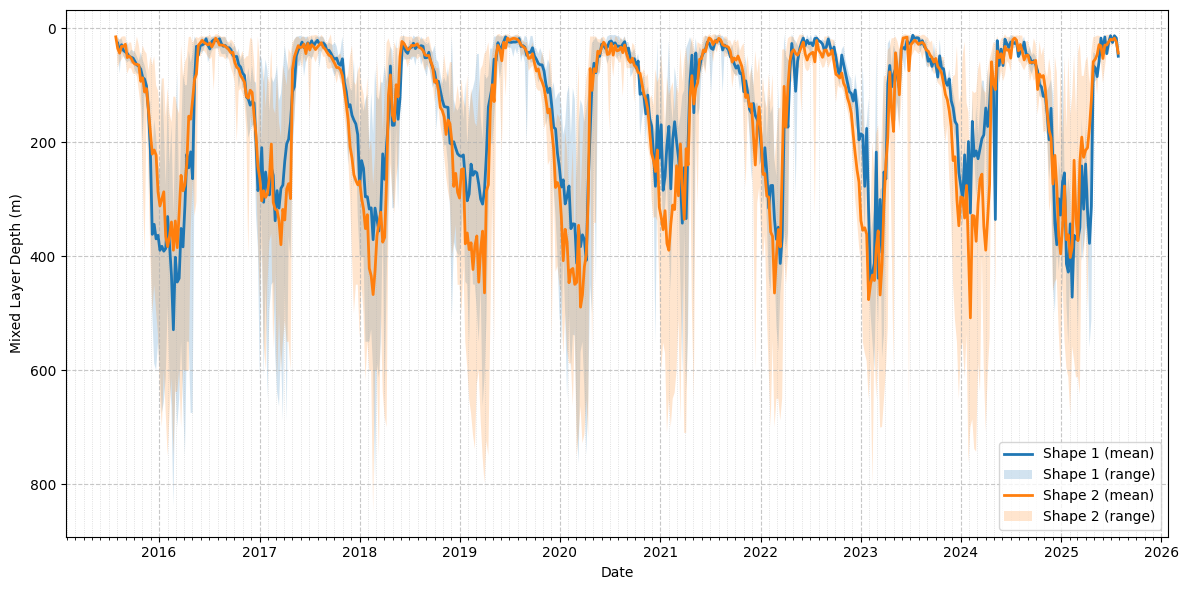

In [53]:
#Plotting 
fig, ax = plt.subplots(figsize=(12, 6))

# Shape 1 Mea
ax.plot(weekly1["date"], weekly1["MLD_mean"], label="Shape 1 (mean)", linewidth=2)
ax.fill_between(
    weekly1["date"],
    weekly1["MLD_min"],
    weekly1["MLD_max"],
    alpha=0.2,
    label="Shape 1 (range)"
)
# Shape 2 
ax.plot(weekly2["date"], weekly2["MLD_mean"], label="Shape 2 (mean)", linewidth=2)
ax.fill_between(
    weekly2["date"],
    weekly2["MLD_min"],
    weekly2["MLD_max"],
    alpha=0.2,
    label="Shape 2 (range)"
)
# Invert y-axis (MLD increases downward)
ax.invert_yaxis()

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Mixed Layer Depth (m)")

# Ticks: yearly majors, monthly minors
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_locator(MonthLocator())

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6, alpha=0.5)

# Legend
ax.legend()

fig.tight_layout()
plt.show()

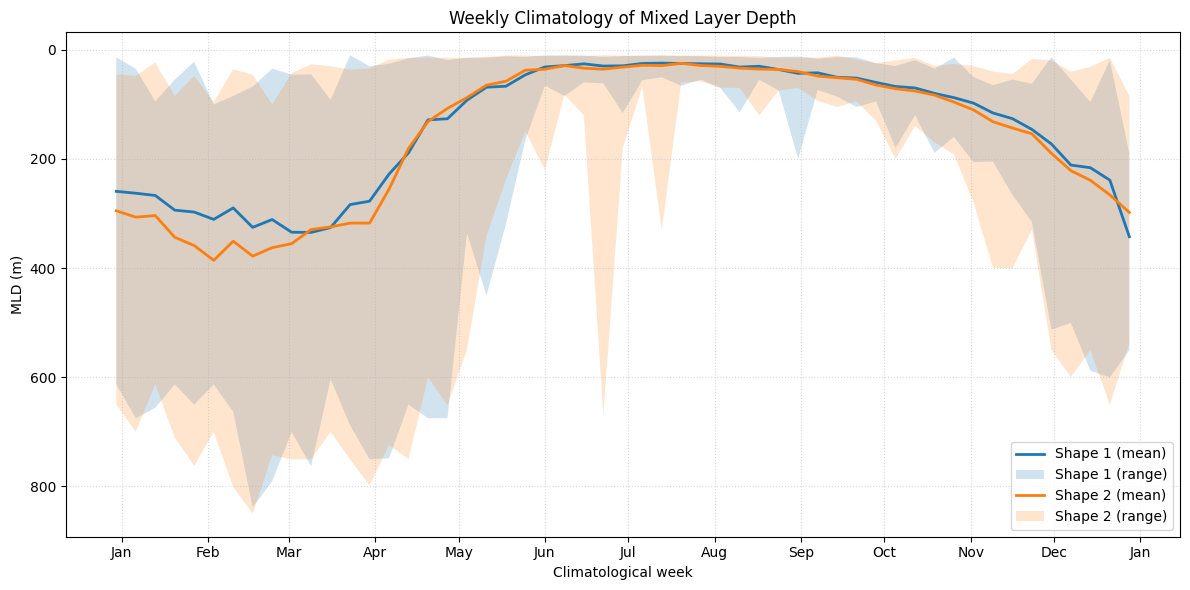

In [54]:
# Creataing MLD Climatology per region
clim1 = (
    shape1.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_min=("MLD", "min"),
              MLD_max=("MLD", "max")
          )
          .reset_index()
)

clim2 = (
    shape2.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_min=("MLD", "min"),
              MLD_max=("MLD", "max")
          )
          .reset_index()
)


def week_to_date(df):
    dates = [dt.date.fromisocalendar(2020, int(w), 1) for w in df["iso_week"]]
    df["date"] = pd.to_datetime(dates)
    return df

clim1 = week_to_date(clim1)
clim2 = week_to_date(clim2)

fig, ax = plt.subplots(figsize=(12,6))

# Region 1
ax.plot(clim1["date"], clim1["MLD_mean"], linewidth=2, label="Shape 1 (mean)")
ax.fill_between(clim1["date"], clim1["MLD_min"], clim1["MLD_max"],
                alpha=0.2, label="Shape 1 (range)")

# Region 2
ax.plot(clim2["date"], clim2["MLD_mean"], linewidth=2, label="Shape 2 (mean)")
ax.fill_between(clim2["date"], clim2["MLD_min"], clim2["MLD_max"],
                alpha=0.2, label="Shape 2 (range)")

# Invert depth
ax.invert_yaxis()

# Format ticks: month = major tick
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b"))

ax.grid(True, linestyle=":", alpha=0.5)
ax.set_xlabel("Climatological week")
ax.set_ylabel("MLD (m)")
ax.set_title("Weekly Climatology of Mixed Layer Depth")

ax.legend()
plt.tight_layout()
plt.show()

## BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis

In [28]:
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dt

In [29]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

df = df.filter(
    pl.col("CHLA_ADJUSTED").is_not_null()
)
df.head()


# QC Filtering on CHLA_ADJUSTED data

df = df.filter(pl.col('CHLA_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data

### Depth Integrating CHL-a

In [30]:
# Creating a depth integrated Chlorophyll column dataframe

# Filtering the between 10m to 500m. (Including, typical euphotic zone depth and avoiding surface [<10m] Tanner et al. 2024)
# Sorting by Depth and profile
df_filtered = (
    df.filter((pl.col('PRES_ADJUSTED') >= 10) & (pl.col('PRES_ADJUSTED') <= 500))
      .sort(['PLATFORM_NUMBER', 'CYCLE_NUMBER', 'PRES_ADJUSTED'])
)

# Computing depth-integrated Chlorophyll per profile

# Compute depth-integrated CHL using trapezoidal rule per profile (also used in Tanner et al. 2024)
# Might be useful to integrate euphotic zone values
integrated = (
    df_filtered
    .group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True)
    .map_groups(lambda g: pl.DataFrame({
        "PLATFORM_NUMBER": [g["PLATFORM_NUMBER"][0]],
        "CYCLE_NUMBER": [g["CYCLE_NUMBER"][0]],
        "DEPTH_INT_CHL": [np.trapezoid(g["CHLA_ADJUSTED"].to_numpy(), # Trapezoid integration is consistant with other integration methods (Tanner et al. 2024))
                                   g["PRES_ADJUSTED"].to_numpy())]
    }))
)

In [31]:
# Furher analysis and plotting can be done based on 'integrated' DataFrame
# Joining CHL replicating to dataframe
df = df.join(integrated, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME,region,DEPTH_INT_CHL
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns],str,f32
null,null,null,99999,"""""",99999,0.001833,0.001833,0.000367,1,"""D""",2,null,null,null,99999,"""""",99999,0.464015,null,null,0,"""R""",0,1.692505,0.831652,null,1,"""A""",3,6,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6901520,1,18.42,18.42,2.4,1,"""D""",1,35.178001,35.178001,0.01,8,"""D""",8,8.1722,8.1722,0.002,8,"""D""",8,1,61.832245,-23.3774,2013-05-10 12:39:00,"""shape2""",70.058502
null,null,null,99999,"""""",99999,0.001694,0.001694,0.000339,1,"""D""",2,null,null,null,99999,"""""",99999,0.9911,null,null,0,"""R""",0,1.6498,0.8103,null,1,"""A""",3,6,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6901520,1,19.200001,19.199999,2.4,1,"""D""",1,35.177219,35.177219,0.01,8,"""D""",8,8.172,8.172,0.002,8,"""D""",8,1,61.832245,-23.3774,2013-05-10 12:39:00,"""shape2""",70.058502
null,null,null,99999,"""""",99999,0.001733,0.001733,0.000347,1,"""D""",2,null,null,null,99999,"""""",99999,0.805751,null,null,0,"""R""",0,1.777446,0.874123,null,1,"""A""",3,6,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6901520,1,19.92,19.92,2.4,1,"""D""",1,35.176563,35.176563,0.01,8,"""D""",8,8.1668,8.1668,0.002,8,"""D""",8,1,61.832245,-23.3774,2013-05-10 12:39:00,"""shape2""",70.058502
null,null,null,99999,"""""",99999,0.001728,0.001728,0.000346,1,"""D""",2,null,null,null,99999,"""""",99999,0.63971,null,null,0,"""R""",0,1.646697,0.808749,null,1,"""A""",3,6,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6901520,1,20.620001,20.620001,2.4,1,"""D""",1,35.175976,35.175976,0.01,8,"""D""",8,8.159577,8.159577,0.002,8,"""D""",8,1,61.832245,-23.3774,2013-05-10 12:39:00,"""shape2""",70.058502
null,null,null,99999,"""""",99999,0.001567,0.001567,0.000313,1,"""D""",2,null,null,null,99999,"""""",99999,0.9911,null,null,0,"""R""",0,1.524058,0.747429,null,1,"""A""",3,6,null,null,null,99999,"""""",99999,…,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,6901520,1,21.42,21.42,2.4,1,"""D""",1,35.175087,35.175087,0.01,8,"""D""",8,8.142689,8.142689,0.002,8,"""D""",8,1,61.832245,-23.3774,2013-05-10 12:39:00,"""shape2""",70.058502


In [32]:
# Keep one row per profile for climatology
profiles = (
    df
    .select([
        "PLATFORM_NUMBER",
        "CYCLE_NUMBER",
        "DEPTH_INT_CHL",
        "TIME",        # adjust name if your time column is different
        "LATITUDE",
        "LONGITUDE",
        "region"
    ])
    .unique(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .filter(pl.col("DEPTH_INT_CHL").is_not_null())
)

# Adding month to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.month().alias("month")   # 1–12
)

# Adding Week to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")   # 1–52
)


### Assesing Profile nº 

<Figure size 1000x600 with 0 Axes>

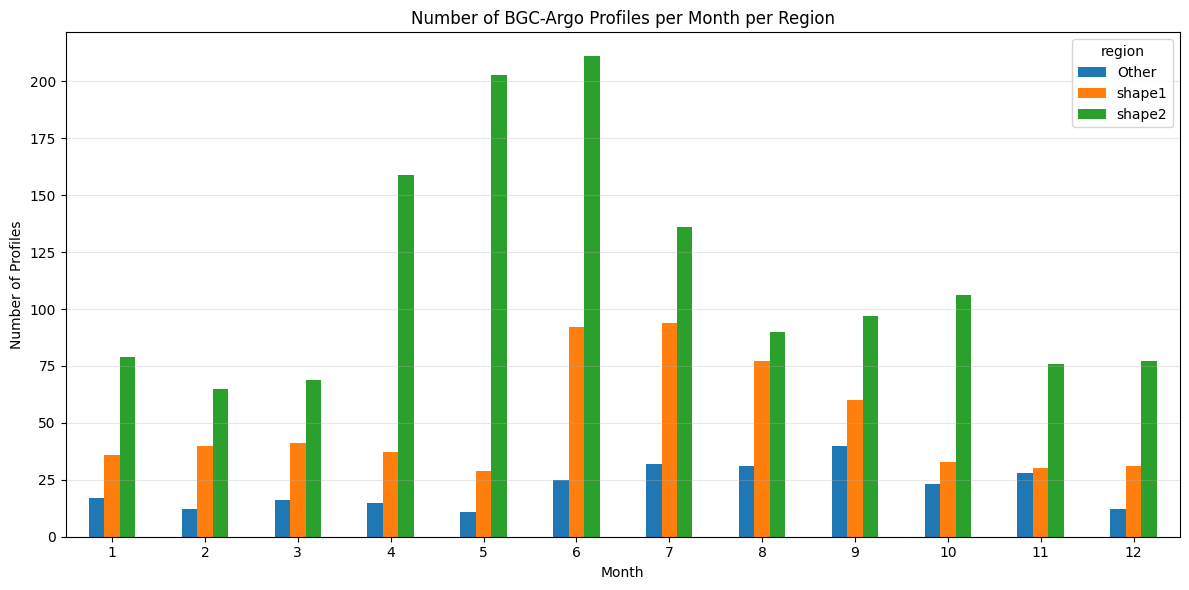

<Figure size 1200x600 with 0 Axes>

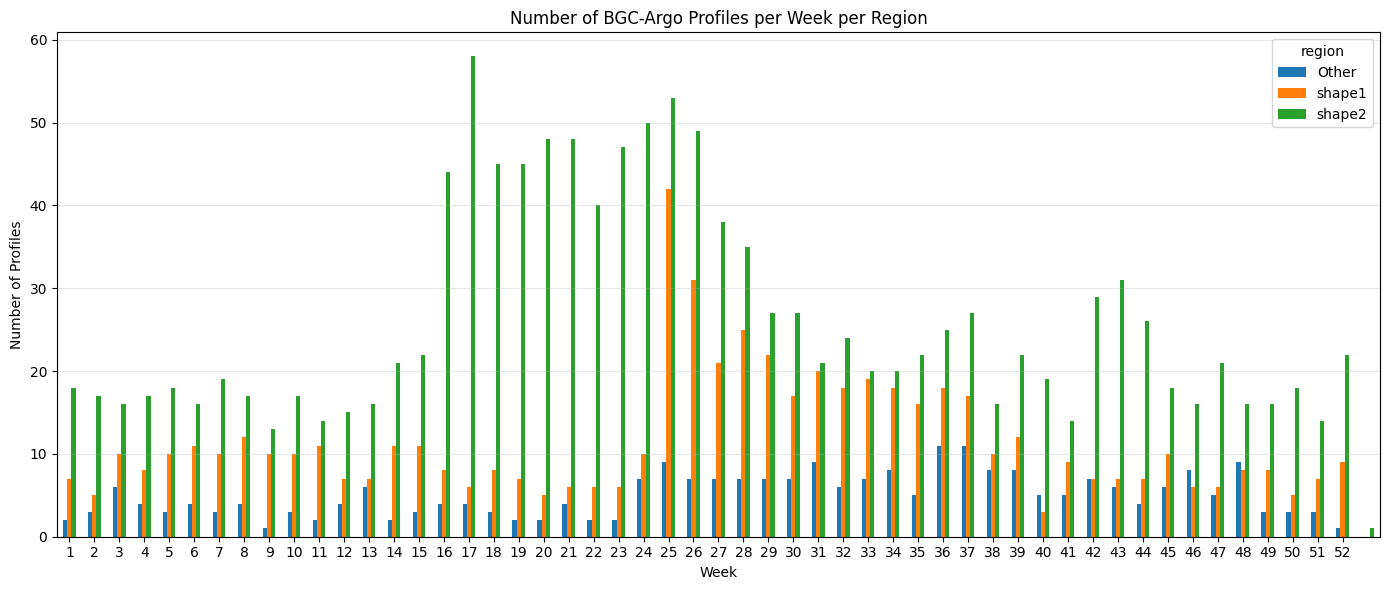

In [33]:
# Plottinhg number of profiles per month and week per region
profiles_per_month = (
    profiles
    .group_by("region","month")
    .agg(
        pl.len().alias("n_profiles")
    )
    .sort("month")
)


ppm = profiles_per_month.to_pandas()

# Pivot to wide format for grouped bars
ppm_wide = ppm.pivot(index="month", columns="region", values="n_profiles")

plt.figure(figsize=(10, 6))

ppm_wide.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Month")
plt.ylabel("Number of Profiles")
plt.title("Number of BGC-Argo Profiles per Month per Region")
plt.xticks(ticks=range(0, 12), labels=range(1, 13), rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

profiles_per_week = (
    profiles
    .group_by("region","week")
    .agg(
        pl.len().alias("n_profiles")
    )
    .sort("week")
)

ppw = profiles_per_week.to_pandas()

# Pivot to wide format for grouped bars
ppw_wide = ppw.pivot(index="week", columns="region", values="n_profiles")

plt.figure(figsize=(12, 6))
ppw_wide.plot(kind="bar", figsize=(14, 6))
plt.xlabel("Week")
plt.ylabel("Number of Profiles")
plt.title("Number of BGC-Argo Profiles per Week per Region")
plt.xticks(ticks=range(0, 52), labels=range(1, 53), rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()


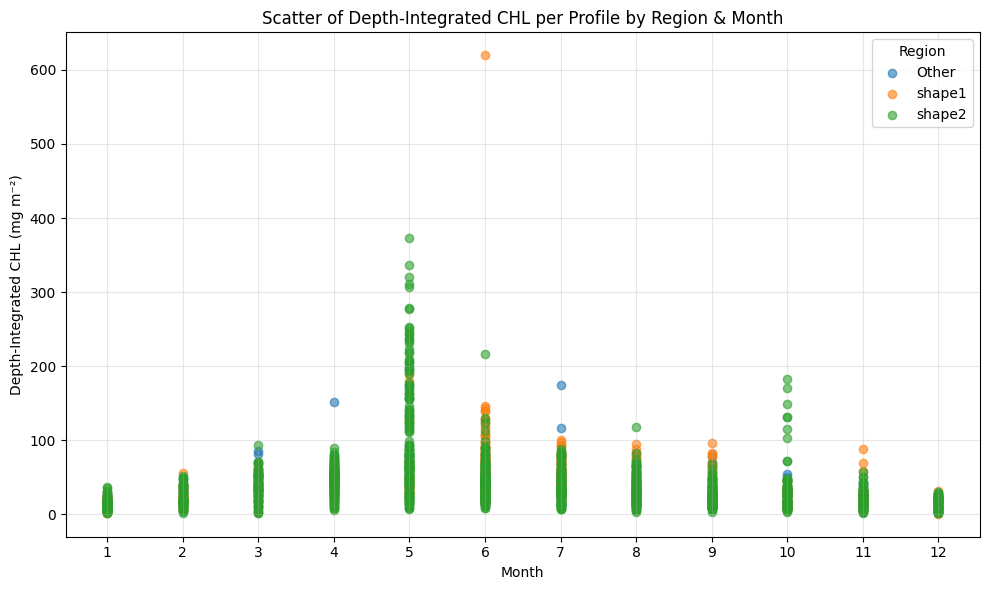

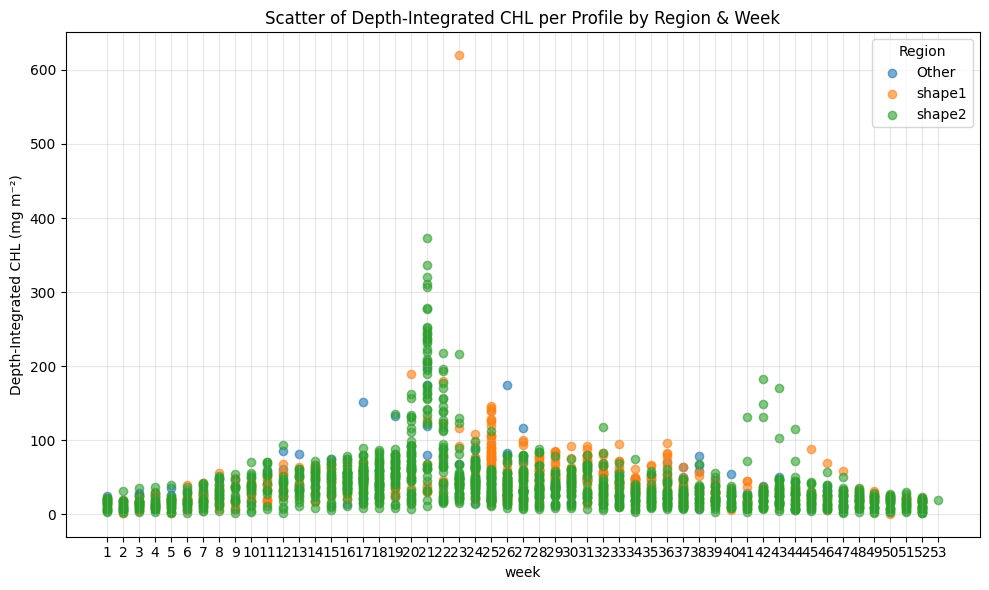

In [55]:
profiles_pd = profiles.to_pandas()

plt.figure(figsize=(10,6))

# Scatter: month on x, depth-integrated CHL on y, colour by region
for region_name, grp in profiles_pd.groupby("region"):
    plt.scatter(
        grp["month"], 
        grp["DEPTH_INT_CHL"], 
        alpha=0.6, 
        label=region_name
    )

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Depth-Integrated CHL (mg m⁻²)")
plt.title("Scatter of Depth-Integrated CHL per Profile by Region & Month")
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
# Scatter: month on x, depth-integrated CHL on y, colour by region
for region_name, grp in profiles_pd.groupby("region"):
    plt.scatter(
        grp["week"], 
        grp["DEPTH_INT_CHL"], 
        alpha=0.6, 
        label=region_name
    )

plt.xticks(range(1,54))
plt.xlabel("week")
plt.ylabel("Depth-Integrated CHL (mg m⁻²)")
plt.title("Scatter of Depth-Integrated CHL per Profile by Region & Week")
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Creating A CHL-a Climatology

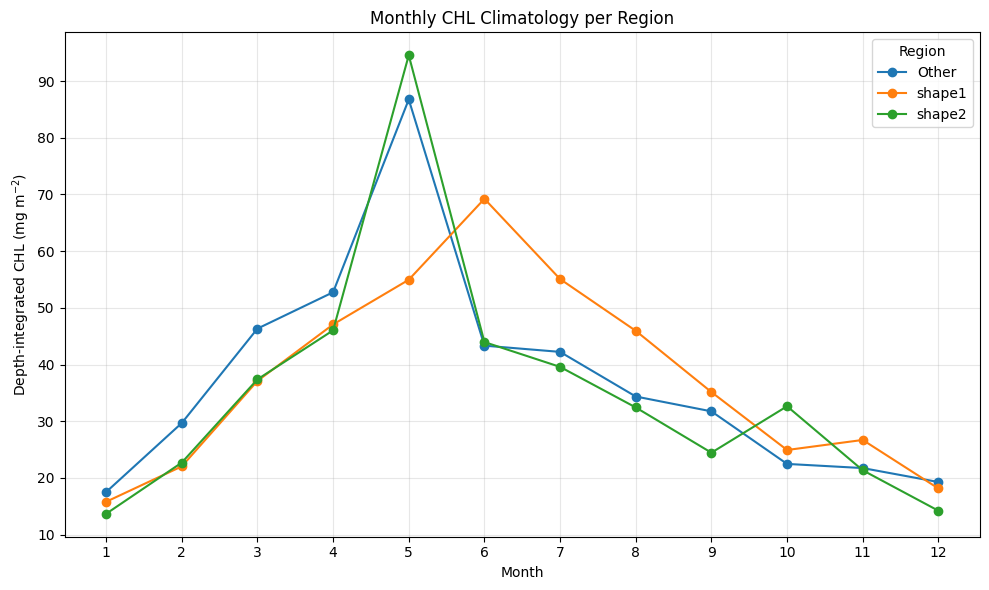

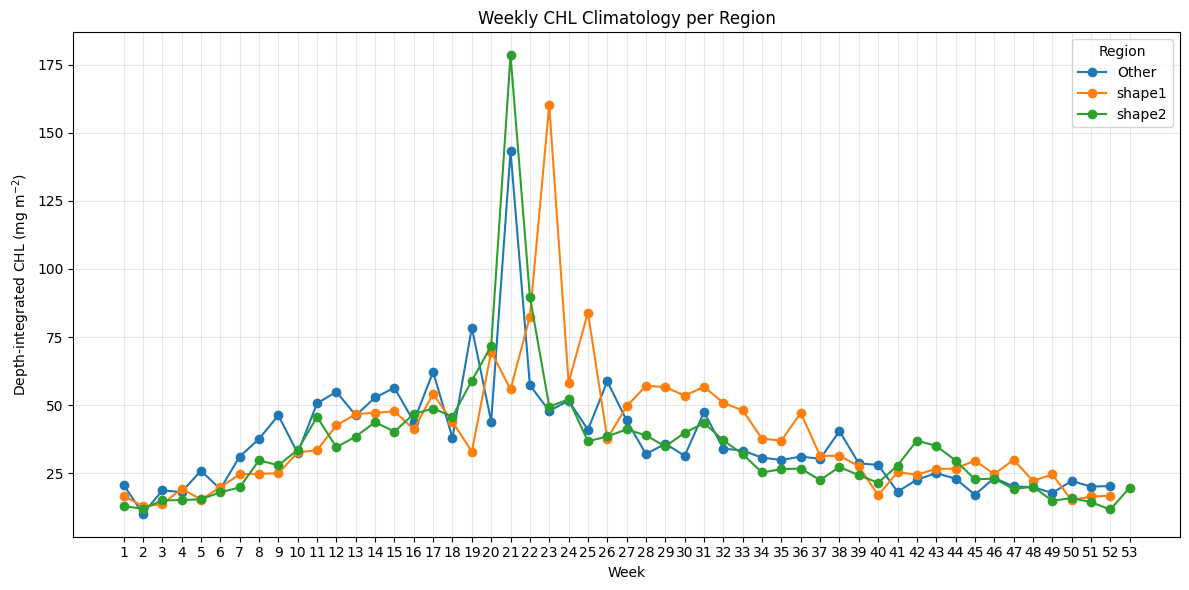

In [35]:


monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 6))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["month"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Monthly CHL Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    #plt.fill_between(
    #    group["week"],
    #    group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2,
    #)
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")    
plt.title("Weekly CHL Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Euphotic zone integration
Calculating Euphotic zone to integrate CHL within this line